# Fly Hemibrain

Playing around with some basic connectome data, from the [Fly Hemibrain](https://www.janelia.org/project-team/flyem/hemibrain) project. If you scroll down that page a little, under the heading "Resources and relevant technologies", the first link "Compact connection matrix summary" is a zip file with three `.csv` files (and a useful README), those files need to be moved into the directory `/notebooks/hemibrain/exported-traced-adjacencies/` for this script. I didn't want to post those files to a public github repo since (a) they're not my data and (b) they're like, a few hundred megabytes in total.

In [1]:
"""Playing around with the fly hemibrain data"""

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import time

## Load the graph

In [2]:
# Step 1: Just reading some csv files and attempting to make a networkx graph

directory = "/notebooks/nx_graph_utils/hemibrain/exported-traced-adjacencies/"

print("Attempting to read files in directory", directory)

nodes_file = "traced-neurons.csv"
edges_file = "traced-total-connections.csv"

edge_data = open(directory+edges_file, "r")
next(edge_data, None)  # skip the first line of the file, which is just a header row

t_start = time.time()
FlyBrain = nx.parse_edgelist(edge_data, delimiter=",", create_using=nx.DiGraph, nodetype=int, data=[("n_synapses", int)])
t_end = time.time()

print("Read in {} nodes and {} edges in {} s".format(nx.number_of_nodes(FlyBrain), nx.number_of_edges(FlyBrain), t_end-t_start))


print(nx.info(FlyBrain))

Attempting to read files in directory /notebooks/nx_graph_utils/hemibrain/exported-traced-adjacencies/
Read in 21662 nodes and 3413160 edges in 18.295302152633667 s
Name: 
Type: DiGraph
Number of nodes: 21662
Number of edges: 3413160
Average in degree: 157.5644
Average out degree: 157.5644


It can take a while to run computations, so be choosy about what you try to run. Also, the adjacency matrix is 20k x 20k, so don't try to naively take third powers of it.

In [3]:
from nx_graph_utils.graphstatistics import linearalgebra

# linearalgebra.nfftriads(FlyBrain)  # Kills the notebook kernel, at least on my laptop.

t_start = time.time()
trans_flybrain = nx.transitivity(FlyBrain)
t_end = time.time()
print("Computed transitivity: {}".format(trans_flybrain))
print("Computation took {} s".format(t_end - t_start))

Computed transitivity: 0.16152591521646892
Computation took 186.56738376617432 s


## Assortativity

The assortivity coefficient is the correlation coefficient between the degrees of nodes joined by an edge. To elaborate, we think of two random variables X and Y which represent the degree of each node, and each edge represents one sample. We're computing the correlation coefficient between X and Y across all edges.

The unweighted case treats all edges equally (i.e. all edges have weight 1). In the weighted case, the number of synapses between the pre- and post-synaptic neurons weights the contribution of each edge.

In [3]:
print("Computing assortativity coefficient...")
t_start = time.time()
assort_in_in = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="in")
t_end = time.time()
print("Got in-degree/in-degree assortavity coefficient of {} in {} s".format(assort_in_in, t_end - t_start))
assort_in_out = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="out")
assort_out_in = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out",y="in")
assort_out_out =nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out", y="out")

print("Unweighted Assortativity Coefficients:")
print(f"{'v sink, source >':>17}|{'in':<16}{'out':<16}")
print("-" * (17 + 1 + 16 + 16))
print(f"{'in':<17}|{assort_in_in:<16.10f}{assort_in_out:<16.10f}")
print(f"{'out':<17}|{assort_out_in:<16.10f}{assort_out_out:<16.10f}")

Computing assortativity coefficient...
Got in-degree/in-degree assortavity coefficient of 0.021227025736457995 in 19.825934410095215 s
Unweighted Assortativity Coefficients:
 v sink, source >|in              out             
--------------------------------------------------
in               |0.0212270257    0.0132345597    
out              |-0.0223338001   -0.0096649372   


In [ ]:
wt_ass_ii = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="in", weight="n_synapses")
wt_ass_io = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="in",y="out", weight="n_synapses")
wt_ass_oi = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out",y="in", weight="n_synapses")
wt_ass_oo = nx.algorithms.degree_pearson_correlation_coefficient(FlyBrain, x="out", y="out", weight="n_synapses")

print("Unweighted Assortativity Coefficients:")
print(f"{'v sink, source >':>17}|{'in':<16}{'out':<16}")
print("-" * (17 + 1 + 16 + 16))
print(f"{'in':<17}|{wt_ass_ii:<16.10f}{wt_ass_io:<16.10f}")
print(f"{'out':<17}|{wt_ass_oi:<16.10f}{wt_ass_oo:<16.10f}")

## Pair and Triplet motifs

Let's see if we can simply enumerate all the pair and triplet motifs in the hemibrain. First, we'll ignore cell type (since there's something like 4000 identified cell types in the fly brain, and no easy way to distinguish excitatory cells from inhibitory) and just look at the four possible ways that a pair of identified neurons can connect, then all the ways a triplet can.

For pairs, we'll have an array called `pair_motifs` which counts the number of disconnected pairs, pairs where there is a one-way connection from lower ID# to higher ID#, pairs where there is a one-way connection in the other direction, and pairs that are reciprocally connected. In the end, we'll have `sum(pair_motifs) == (n_nodes choose 2)` and `pair_motifs[1] + pair_motifs[2] + 2 * pair_motifs[3] == n_edges`.

For triplets, things will be trickier, so we'll cross that bridge when we come to it.

In [3]:
# pair motifs: should be easy, since this is basically just counting edges.
pair_motifs = np.zeros(4)

print("Using the underlying undirected graph to get all pairs that have an edge (this might take a while...)")
t_start = time.time()
n_nodes = nx.number_of_nodes(FlyBrain)
pair_motifs[0] = n_nodes * (n_nodes - 1) // 2  # assume an empty graph
uFlyBrain = FlyBrain.to_undirected(as_view=True)
for e in uFlyBrain.edges:
    lohi = (min(e), max(e)) in FlyBrain.edges
    hilo = (max(e), min(e)) in FlyBrain.edges
    pair_motifs[0] -= lohi + hilo
    pair_motifs[lohi + 2 * hilo] += 1
t_end = time.time()

print("Done! Took",t_end - t_start,"s")
print("pair_motifs:",pair_motifs)

Using the underlying undirected graph to get all pairs that have an edge (this might take a while...)
Done! Took 20.115858554840088 s
pair_motifs: [2.31197131e+08 9.95839000e+05 1.14979700e+06 6.33762000e+05]


Text(0, 0.5, 'Number of pairs')

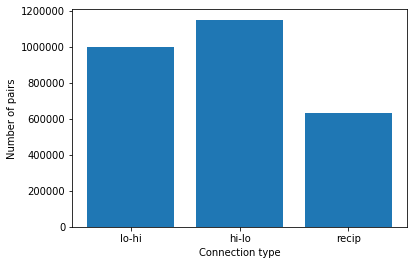

In [19]:
# plt.bar(range(4), pair_motifs)
plt.bar([1,2,3], pair_motifs[1:])
plt.xticks([1,2,3],labels=["lo-hi","hi-lo","recip"])
plt.xlabel("Connection type")
plt.ylabel("Number of pairs")

As expected, the graph is pretty sparse so the vast majority of pairs are disconnected (notice that the first entry in `pair_motifs` is a different scale of magnitude than the rest). So, the plot above only shows the counts for the pairs that are connected. The labels "lo-hi" and "hi-lo" refer to pairs of cells with only a one-way connection, separated by whether the arrow points from the lower ID# to the higher ID# or vice-versa. Since the labels should be essentially arbitrary, any discrepancy (if it's even significant) is an artifact of the labeling process, and not scientifically interesting.

Also, there's no real reason to split up one-way arrows this way, except in the behind-the-scenes of the algorithm. What we're really interested in is, how many pairs of neurons synapse unidirectionally vs. reciprocally? And can we see it a little more clearly in the labels on the x axis? See below:

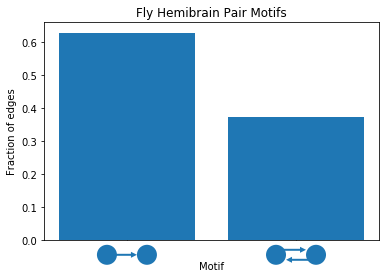

In [58]:
import matplotlib.patches as mpatches
from matplotlib.offsetbox import DrawingArea, OffsetImage, AnnotationBbox

n_edges = nx.number_of_edges(FlyBrain)
n_pairs = n_nodes * (n_nodes - 1) // 2

# The second answer from stackoverflow:
fig, ax = plt.subplots()
# Option 1: Normalize by number of pairs
# ax.bar([1,2], [(pair_motifs[1] + pair_motifs[2]) / n_pairs, pair_motifs[3] / n_pairs])
# plt.ylabel("(1) Fraction of pairs")

# Option 2: Normalize by number of edges. In this case, double count reciprocal connections
ax.bar([1,2], [(pair_motifs[1] + pair_motifs[2]) / n_edges, 2 * pair_motifs[3] / n_edges])
plt.ylabel("(2) Fraction of edges")

plt.xlabel("Motif")
plt.title("Fly Hemibrain Pair Motifs")

ax.get_xaxis().set_ticks([1,2])
# ax.get_xaxis().set_ticklabels([])

# one-way arrow motif:
motif1_drawing = DrawingArea(40, 20, 20, 10)
m1_c1 = mpatches.Circle((-20,0), 10)
m1_c2 = mpatches.Circle((20,0), 10)
m1_a1 = mpatches.Arrow(-20, 0, 30, 0, width=10)
motif1_drawing.add_artist(m1_a1)
motif1_drawing.add_artist(m1_c1)
motif1_drawing.add_artist(m1_c2)

motif1_ab = AnnotationBbox(motif1_drawing, (1,0),
                    xybox=(0,-5),
                    xycoords=("data","axes fraction"),
                    box_alignment=(0.5, 1),
                    boxcoords="offset points",
                    bboxprops={"edgecolor" : "none"})
ax.add_artist(motif1_ab)

# two-way arrow motif:
motif2_drawing = DrawingArea(40,20,20,10)
m2_c1 = mpatches.Circle((-20,0), 10)
m2_c2 = mpatches.Circle((20,0), 10)
m2_a1 = mpatches.Arrow(-20,5,30,0,width=10)
m2_a2 = mpatches.Arrow(20, -5, -30, 0, width=10)
motif2_drawing.add_artist(m2_a1)
motif2_drawing.add_artist(m2_a2)
motif2_drawing.add_artist(m2_c1)
motif2_drawing.add_artist(m2_c2)

motif2_ab = AnnotationBbox(motif2_drawing, (2,0),
                    xybox=(0,-5),
                    xycoords=("data","axes fraction"),
                    box_alignment=(0.5, 1),
                    boxcoords="offset points",
                    bboxprops={"edgecolor" : "none"})
ax.add_artist(motif2_ab)

The number in parentheses on the y-axis lable specifies which option was used in the code above:

**Option 1:** fraction of pairs of neurons that have the given connection motif.

**Option 2:** fraction of edges that connect a pair of neurons with the given connectivity motif. Notice that in this case we count recipricol pairs twice, since two edges participate per pair.

In [ ]:
# triplet motifs are tricky to count accurately.

triplet_motifs = np.zeros(64)
for e in uFlyBrain.edges:
    u,v = (min(e),max(e))
    # to keep track of things, we partition the remaining nodes into 12 sets:
    # First, the four possible neighborhoods (neither, u, v, both), then where the ID falls relative to u and v
    # (less than u, between u and v, and greater than v)

## Plots
Let's try some basic plotting

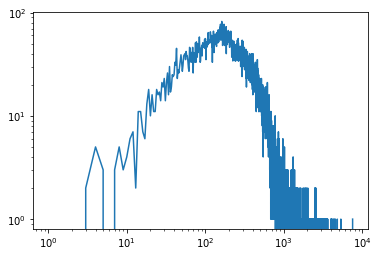

In [3]:
plt.loglog(nx.degree_histogram(FlyBrain))  # degree = in-degree + out-degree, not the most useful

## Misc scratchwork

In [4]:
FlyBrain.in_degree[5813054846]

223

In [5]:
in_out = [(FlyBrain.in_degree[v], FlyBrain.out_degree[v]) for v in FlyBrain.nodes]
print(in_out[:5])
plt.scatter(*in_out)

[(223, 123), (100, 145), (92, 80), (452, 51), (83, 166)]


TypeError: scatter() takes from 2 to 13 positional arguments but 21662 were given

In [12]:
def degrees_by_edges(G, weight_threshold=0, weight_name="weight"):
    """Return an m x 4 numpy array, where m is the number of edges.
    Each row represents a distinct edge, and the columns are (in order):
    pre_in, pre_out, post_in, post_out
    That is, the in-degree and out-degree of the pre- and post-synatpic neuron of each edge.
    
    Ignores edges where edge attribute `weight_name` is strictly less than weight_threshold"""
    pass
## Poking around in the networkx docs has revealed this function is already implemented, here: 